# Autoencoder for Consumer perception on price prmotion

In [1]:
# Libraries
import numpy as np
import pandas as pd
from tensorflow.keras.layers import  Dense, BatchNormalization, Activation, Add
from tensorflow.keras import Model
import tensorflow.keras as keras
from keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import regularizers

In [2]:
from sklearn.model_selection import train_test_split
from  sklearn.preprocessing import StandardScaler

In [3]:
#libraries
import math
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## 1. Import data

In [5]:
# Import data 
input_data=pd.read_csv("https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/data/Sales_Product_Price_by_Store.csv",delimiter=",",sep=",")

In [4]:
price_data=pd.read_csv("C:/Users/AMINE/Documents/PhD/AI Phd/Pricing and Golden ratio/Data_Amazon.csv",delimiter=';')

In [5]:
price_data.head()

,InitialPrice,PromotionPrice,rating,category
0,14.99,30.00,4.4,Literature and fiction
1,15.99,30.00,4.5,Literature and fiction
2,13.99,27.00,4.3,Literature and fiction
3,14.99,17.00,4.6,Literature and fiction
4,14.99,28.99,4.4,Literature and fiction


### 2. Data Processing

In [6]:
price_data.dtypes

InitialPrice      float64
PromotionPrice    float64
rating            float64
category           object
dtype: object

In [7]:
price_data.shape

(50, 4)

In [40]:
#X=price_data[['discountedPrice','price']]

In [6]:
price_data["category"]=price_data["category"].astype('category')
price_data["category"]=price_data["category"].cat.codes

In [7]:
X=price_data[["InitialPrice","PromotionPrice"]]

In [8]:
X=X.astype('float32')

In [9]:
X.shape

(100, 2)

In [ ]:
# Data processing

In [10]:
X=StandardScaler().fit_transform(X)

In [109]:
np.max(X)

5.7479396

In [11]:
(np.sqrt(5)+1)/2

1.618033988749895

In [12]:
X=np.asarray(X)

In [13]:
x_train, x_test = train_test_split(X,test_size = 0.2, random_state = 2)

In [111]:
X

array([[-1.09152414e-01,  8.77552554e-02],
       [-1.76353380e-02,  8.77552554e-02],
       [-2.00669467e-01, -8.37869123e-02],
       [-1.09152414e-01, -6.55594110e-01],
       [-1.09152414e-01,  3.00027113e-02],
       [-3.83703619e-01, -6.56165957e-01],
       [-1.09152414e-01, -2.71780118e-02],
       [-5.66737771e-01, -7.12774873e-01],
       [-2.00669467e-01, -2.66061909e-02],
       [-2.92186528e-01, -2.66061909e-02],
       [-2.00669467e-01, -8.66459012e-02],
       [ 9.89052415e-01,  1.21535921e+00],
       [-3.83703619e-01, -4.26871270e-01],
       [ 9.52445567e-01,  1.22851074e+00],
       [ 2.56915867e-01,  3.73658866e-01],
       [-2.92186528e-01, -6.56165957e-01],
       [-1.09152414e-01,  8.77552554e-02],
       [-6.58254802e-01, -4.84051943e-01],
       [-9.32806075e-01,  2.30707064e-01],
       [-5.66737771e-01, -5.98413408e-01],
       [ 7.11361617e-02,  8.77552554e-02],
       [-5.66737771e-01, -7.15633869e-01],
       [ 4.53533840e+00,  2.94621944e+00],
       [ 1.

### 3. Autoencoder: Model Construction

In [14]:
# Encoder SIR 

latent_dim = 1

encoder_inputs =  keras.Input(shape=(2,))
x = layers.Dense(10, activation='linear')(encoder_inputs)
x = layers.Dense(5, activation='linear')(x)
x = layers.Dense(3, activation='linear')(x)

z = layers.Dense(latent_dim, activation='relu',name="z")(x)

encoder = keras.Model(encoder_inputs, z, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
 z (Dense)                   (None, 1)                 4         
                                                                 
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Decoder SIR

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(3, activation='linear')(latent_inputs)
x = layers.Dense(5, activation='linear')(x)
x = layers.Dense(10, activation='linear')(x)
decoder_outputs = layers.Dense(2, activation='linear')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 6         
                                                                 
 dense_4 (Dense)             (None, 5)                 20        
                                                                 
 dense_5 (Dense)             (None, 10)                60        
                                                                 
 dense_6 (Dense)             (None, 2)                 22        
                                                                 
Total params: 108
Trainable params: 108
Non-trainable params: 0
_________________________________________________________________


In [16]:
class AE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(AE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.golden_loss_tracker = keras.metrics.Mean( name="golden_loss")
       

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.golden_loss_tracker,
          
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_sum(tf.reduce_sum((data-reconstruction)**2, axis=1 ))
            
            phi=(np.sqrt(5)+1)/2
            golden_loss=(z-phi)**2
            golden_loss = tf.reduce_sum(tf.reduce_sum(golden_loss,axis=1))
            
            
            total_loss = reconstruction_loss+ golden_loss
            
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.golden_loss_tracker.update_state(golden_loss)
       
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "golden_loss": self.golden_loss_tracker.result(),

        }

### 4. AutoEncoder Model Training 

In [17]:
autoencoder = AE(encoder, decoder)

In [18]:
autoencoder.compile(optimizer=keras.optimizers.Adam())

In [19]:
#Training
hist=autoencoder.fit(X,epochs=2000, batch_size=128)

Epoch 1/2000
1/1 [==============================] - 1s 1s/step - loss: 446.4436 - reconstruction_loss: 199.7588 - golden_loss: 246.6849
Epoch 2/2000
1/1 [==============================] - 0s 8ms/step - loss: 443.4052 - reconstruction_loss: 199.4929 - golden_loss: 243.9123
Epoch 3/2000
1/1 [==============================] - 0s 8ms/step - loss: 440.1576 - reconstruction_loss: 199.1574 - golden_loss: 241.0002
Epoch 4/2000
1/1 [==============================] - 0s 9ms/step - loss: 436.7606 - reconstruction_loss: 198.7566 - golden_loss: 238.0039
Epoch 5/2000
1/1 [==============================] - 0s 8ms/step - loss: 433.1622 - reconstruction_loss: 198.2978 - golden_loss: 234.8643
Epoch 6/2000
1/1 [==============================] - 0s 11ms/step - loss: 429.4345 - reconstruction_loss: 197.7802 - golden_loss: 231.6543
Epoch 7/2000
1/1 [==============================] - 0s 13ms/step - loss: 425.6693 - reconstruction_loss: 197.2109 - golden_loss: 228.4584
Epoch 8/2000
1/1 [======================

### 5. Model Evaluation

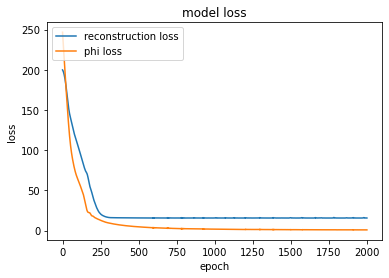

In [20]:
# summarize history for loss
plt.plot(hist.history['reconstruction_loss'])
plt.plot(hist.history['golden_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['reconstruction loss', 'phi loss'], loc='upper left')
plt.show()

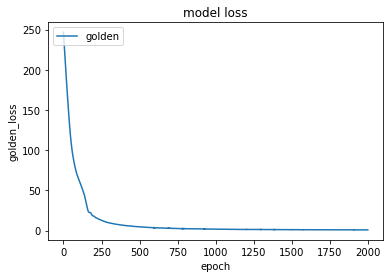

In [21]:
# summarize history for Golden_loss
plt.plot(hist.history['golden_loss'])
plt.title('model loss')
plt.ylabel('golden_loss')
plt.xlabel('epoch')
plt.legend(['golden'], loc='upper left')
plt.show()

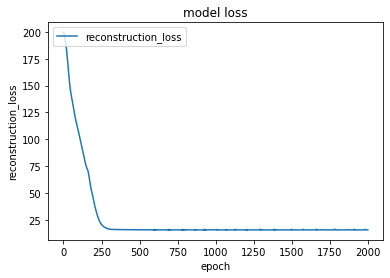

In [22]:
# summarize history for Reconstruction_loss
plt.plot(hist.history['reconstruction_loss'])
plt.title('model loss')
plt.ylabel('reconstruction_loss')
plt.xlabel('epoch')
plt.legend(['reconstruction_loss'], loc='upper left')
plt.show()

### 6. Export Encoded data

In [23]:
encoded_data=autoencoder.encoder(X)
encoded_data

<tf.Tensor: shape=(100, 1), dtype=float32, numpy=
array([[1.6144309],
       [1.6102381],
       [1.6264672],
       [1.6484202],
       [1.6170716],
       [1.6610245],
       [1.6196862],
       [1.6719983],
       [1.6238527],
       [1.6280454],
       [1.6265979],
       [1.5125592],
       [1.6505401],
       [1.5136349],
       [1.5845873],
       [1.6568317],
       [1.6144309],
       [1.6657329],
       [1.6456287],
       [1.6667693],
       [1.6061713],
       [1.672129 ],
       [1.2709494],
       [1.5248792],
       [1.7086753],
       [1.6228163],
       [1.6608531],
       [1.6102643],
       [1.4508833],
       [1.5130408],
       [1.63066  ],
       [1.6746391],
       [1.6165037],
       [1.6264672],
       [1.6196599],
       [1.6144309],
       [1.6093838],
       [1.6568056],
       [1.6584097],
       [1.6280454],
       [1.6155981],
       [1.7023745],
       [1.6170454],
       [1.6641805],
       [1.6610245],
       [1.6154675],
       [1.6557952],
       [1.

In [24]:
pd.DataFrame(encoded_data).to_csv("C:/Users/AMINE/Documents/PhD/AI Phd/Pricing and Golden ratio/encoded_Gold.csv")

In [25]:
decoded_data=autoencoder.decoder(encoded_data)

In [26]:
X

array([[-1.09152414e-01,  8.77552554e-02],
       [-1.76353380e-02,  8.77552554e-02],
       [-2.00669467e-01, -8.37869123e-02],
       [-1.09152414e-01, -6.55594110e-01],
       [-1.09152414e-01,  3.00027113e-02],
       [-3.83703619e-01, -6.56165957e-01],
       [-1.09152414e-01, -2.71780118e-02],
       [-5.66737771e-01, -7.12774873e-01],
       [-2.00669467e-01, -2.66061909e-02],
       [-2.92186528e-01, -2.66061909e-02],
       [-2.00669467e-01, -8.66459012e-02],
       [ 9.89052415e-01,  1.21535921e+00],
       [-3.83703619e-01, -4.26871270e-01],
       [ 9.52445567e-01,  1.22851074e+00],
       [ 2.56915867e-01,  3.73658866e-01],
       [-2.92186528e-01, -6.56165957e-01],
       [-1.09152414e-01,  8.77552554e-02],
       [-6.58254802e-01, -4.84051943e-01],
       [-9.32806075e-01,  2.30707064e-01],
       [-5.66737771e-01, -5.98413408e-01],
       [ 7.11361617e-02,  8.77552554e-02],
       [-5.66737771e-01, -7.15633869e-01],
       [ 4.53533840e+00,  2.94621944e+00],
       [ 1.

In [ ]:
# Model accuarcy

In [27]:
# calculate root mean squared error
decoded_data=autoencoder.decoder(encoded_data)
trainScore = math.sqrt(mean_squared_error(X, decoded_data))
print('Evaluation Score: %.2f RMSE' % (trainScore))

Evaluation Score: 0.28 RMSE


In [ ]:
############################################################################################

In [35]:
class AE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(AE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
       

    @property
    def metrics(self):
        return [
            self.reconstruction_loss_tracker,
            
          
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_sum(tf.reduce_sum(abs(data-reconstruction)**2, axis=1 ))
            
            
            
            
        grads = tape.gradient(reconstruction_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        
       
        return {
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            

        }

### 7. Variational AutoEncoder: Model Construction

In [68]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [69]:
# Encoder 

latent_dim = 1

encoder_inputs =  keras.Input(shape=(3,))
x = layers.Dense(10, activation='linear')(encoder_inputs)
x = layers.Dense(5, activation='linear')(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 10)           40          ['input_4[0][0]']                
                                                                                                  
 dense_10 (Dense)               (None, 5)            55          ['dense_9[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 1)            6           ['dense_10[0][0]']               
                                                                                            

In [70]:
# Decoder 

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(5, activation='linear')(latent_inputs)
x = layers.Dense(10, activation='linear')(x)
decoder_outputs = layers.Dense(3, activation='linear')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_11 (Dense)            (None, 5)                 10        
                                                                 
 dense_12 (Dense)            (None, 10)                60        
                                                                 
 dense_13 (Dense)            (None, 3)                 33        
                                                                 
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


In [71]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = z_mean*z_mean-z_mean-1
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### 8. VAE Model Tarining

In [72]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [73]:
#Training
history=vae.fit(X,epochs=100, batch_size=128)

Epoch 1/100


ValueError: in user code:

    File "C:\Users\AMINE\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\AMINE\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\AMINE\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\AMINE\AppData\Local\Temp/ipykernel_15288/1404194884.py", line 25, in train_step
        tf.reduce_sum(

    ValueError: Invalid reduction dimension 1 for input with 1 dimensions. for '{{node Sum}} = Sum[T=DT_FLOAT, Tidx=DT_INT32, keep_dims=false](Mean, Sum/reduction_indices)' with input shapes: [?], [2] and with computed input tensors: input[1] = <1 2>.
